# Esempio Extra: Iterative Phase Estimation con 3 iterazioni

Come discusso a lezione il 31 Ottobre, è possibile aumentare l'accuratezza della nostra stima a piacimento (pagandola in risorse utilizzate ovviamente), applicando più volte correzione di fase, stima del bit, misurazione del qubit e reset di quest'ultimo.

In particolare, ci avevate chiesto un esempio di IPE a tre bit di accuratezza per capire come si dovesse effettuare la correzione di fase per le iterazioni successive alla seconda.

Vi riportiamo dunque la stima della fase del gate $\mathbf{T}$, la cui matrice associata è
$$ 
    \mathbf{T} =
    \begin{pmatrix}
        1 & 0\\
        0 & e^{i\pi / 4}
    \end{pmatrix}
$$

In [1]:
# imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np

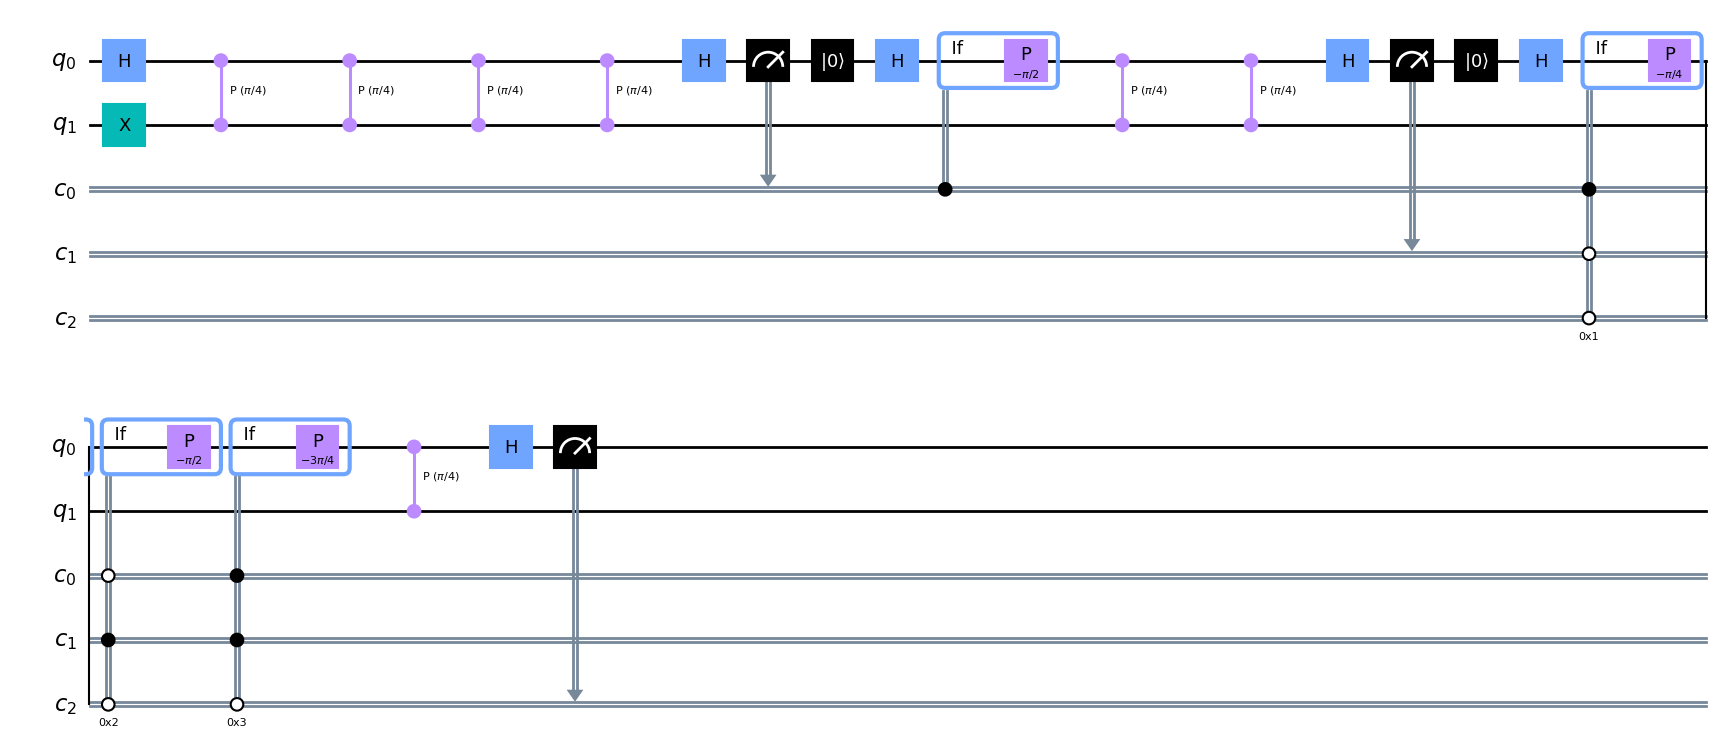

In [2]:
def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 3 bits

    qc = QuantumCircuit(qr, cr)
    
    ### iter1
    angle = np.pi/4
    m = 3
    
    qc.h(0)
    qc.x(1)
    
    for t in range(2**(m-1)):
        qc.cp(angle, 0, 1)
    
    qc.h(0)
    
    qc.measure(0,0)
    
    ### iter2
    qc.reset(0)
    qc.h(0)
    
    with qc.if_test((cr[0], 1)) as else_:
        qc.p(-np.pi/2, 0)

    for t in range(2**(m-2)):
        qc.cp(angle, 0, 1)
    
    qc.h(0)
    
    qc.measure(0,1)
    
    ### iter3
    qc.reset(0)
    qc.h(0)
    
    # first correction: if we measured 1 = 01
    with qc.if_test((cr, 1)) as else_:
        qc.p(-angle, 0)

    # second correction: if we measured 2 = 10    
    with qc.if_test((cr, 2)) as else_:
        qc.p(-np.pi/2, 0)

    # third correction: if we measured 3 = 11      
    with qc.if_test((cr, 3)) as else_:
        qc.p(-3*angle, 0)

    for t in range(2**(m-3)):
        qc.cp(angle, 0, 1)
    
    qc.h(0)
    
    qc.measure(0,2)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = t_gate_ipe_circuit(qr, cr)
qc.draw("mpl")

In [3]:
sim = AerSimulator()

job = sim.run(qc, shots=1000)
counts = job.result().get_counts()

counts

{'001': 1000}

Osserviamo che in effetti otteniamo 
$$
    \theta = 0.001 = \frac{1}{8}
$$
che ci riporta alla fase corretta per $\mathbf{T}$, dato che
$$
    e^{i\pi / 4} = e^{2\pi i / 8}
$$